In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from IPython.display import clear_output
import torchsummary
import torch

import sys
sys.path.append('../..')

from vae import compute_fid_score
from gan import GAN
from rbm import RBM
from dbn import DBN
from load_data import load_mnist

# Load data

In [2]:
X_train, y_train, X_test, y_test = load_mnist(binarize=False)

# GAN

In [3]:
gan_model = GAN(latent_dim=100, negative_slope=0.2)

Epoch 40/500:: loss_disc: 0.7366, loss_gen: 2.0558, D(x): 0.7437, D(G(z)): 0.1571


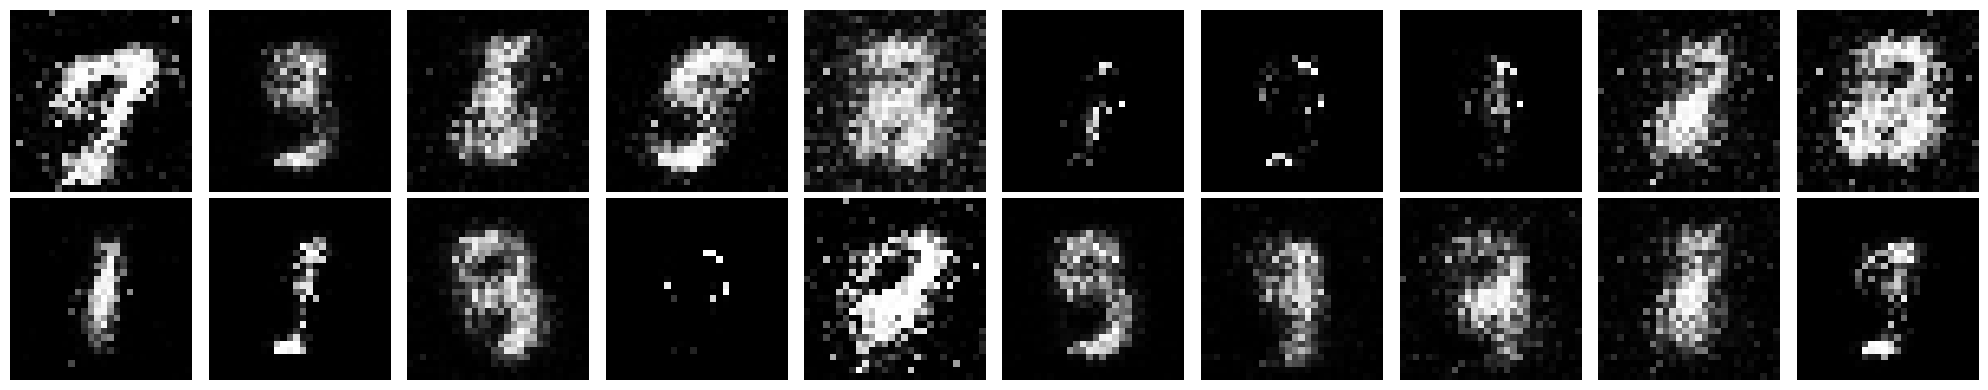

In [4]:
gan_model.train(X_train, epochs=500, learning_rate=3e-4, beta_1=0.9, batch_size=256, n_iters_inner=1)

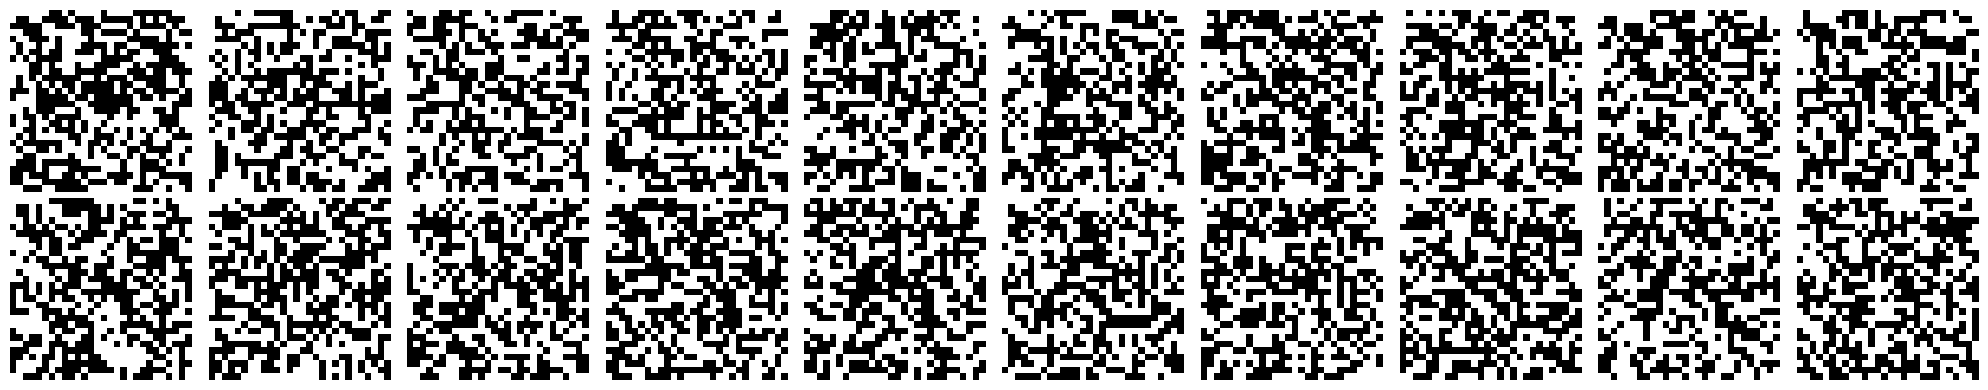

In [ ]:
_= gan_model.generate_data(binarize=True)

In [ ]:
gan_generated_images = gan_model.generer_image_DBN(nb_to_generate=len(X_test[:5000]), plot_=False)
gan_fid_score = compute_fid_score(X_test[:5000], gan_generated_images, device=torch.device("cuda" if torch.cuda.is_available() else "cpu"))
print(f"FID score with GAN: {gan_fid_score:.4f}")

In [78]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Generator model
class Generator(nn.Module):
    def __init__(self, z_dim, h_dim_1, h_dim_2, n_rows, n_cols, n_channels, negative_slope=0.2):
        super(Generator, self).__init__()
        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_channels = n_channels
        self.n_pixels = (self.n_rows) * (self.n_cols)
        self.h_dim_1 = h_dim_1
        self.h_dim_2 = h_dim_2
        self.z_dim = z_dim
        self.negative_slope = negative_slope

        self.fc1 = nn.Linear(z_dim, h_dim_1)
        self.fc2 = nn.Linear(h_dim_1, h_dim_2)
        self.fc3 = nn.Linear(h_dim_2, self.n_pixels)

    def forward(self, z):
        y = torch.nn.functional.leaky_relu(self.fc1(z), negative_slope=self.negative_slope)
        y = torch.nn.functional.leaky_relu(self.fc2(y), negative_slope=self.negative_slope)
        y = torch.tanh(self.fc3(y))

        y = y.view(y.size(0), self.n_channels, self.n_rows, self.n_cols)
        return y

# Discriminator model
class Discriminator(nn.Module):
    def __init__(self, h_dim_2, h_dim_1, z_dim, n_rows, n_cols, n_channels, negative_slope=0.2):
        super(Discriminator, self).__init__()

        self.n_rows = n_rows
        self.n_cols = n_cols
        self.n_channels = n_channels
        self.n_pixels = (self.n_rows) * (self.n_cols)
        self.h_dim_1 = h_dim_1
        self.h_dim_2 = h_dim_2
        self.z_dim = z_dim
        self.negative_slope = negative_slope

        self.fc1 = nn.Linear(self.n_pixels, h_dim_2)
        self.fc2 = nn.Linear(h_dim_2, h_dim_1)
        self.fc3 = nn.Linear(h_dim_1, 1)

    def forward(self, x):
        x = x.view(x.size(0), -1)
        y = torch.nn.functional.leaky_relu(self.fc1(x), negative_slope=self.negative_slope)
        y = torch.nn.functional.leaky_relu(self.fc2(y), negative_slope=self.negative_slope)
        y = torch.sigmoid(self.fc3(y))
        return y

# Parameters
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
lr = 0.0002
z_dim = 100
h_dim_1 = 256
h_dim_2 = 512
n_rows = 28
n_cols = 28
n_channels = 1
batch_size = 128
num_epochs = 100

# Data loading
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
#train_loader = torch.utils.data.DataLoader(
#    torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True),
#    batch_size=batch_size, shuffle=True, num_workers=2)
#train_loader = dataloader

# Initialize generator and discriminator
generator = Generator(z_dim, h_dim_1, h_dim_2, n_rows, n_cols, n_channels).to(device)
discriminator = Discriminator(h_dim_2, h_dim_1, z_dim, n_rows, n_cols, n_channels).to(device)

# Optimizers
optimizer_G = optim.Adam(generator.parameters(), lr=lr)
optimizer_D = optim.Adam(discriminator.parameters(), lr=lr)

# Binary cross entropy loss and noise
criterion = nn.BCELoss()
fixed_noise = torch.randn(64, z_dim, device=device)

# Training loop
for epoch in range(num_epochs):
    for i, (real_images) in enumerate(train_loader):
        # Train discriminator with real images
        real_images = real_images.to(device)

        discriminator.zero_grad()
        real_outputs = discriminator(real_images)
        real_labels = torch.ones_like(real_outputs, device=device)
        d_loss_real = criterion(real_outputs, real_labels)
        d_loss_real.backward()

        # Train discriminator with fake images
        z = torch.randn(batch_size, z_dim, device=device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images.detach())
        fake_labels = torch.zeros_like(fake_outputs, device=device)
        d_loss_fake = criterion(fake_outputs, fake_labels)
        d_loss_fake.backward()
        optimizer_D.step()

        # Train generator
        generator.zero_grad()
        z = torch.randn(batch_size, z_dim, device=device)
        fake_images = generator(z)
        fake_outputs = discriminator(fake_images)
        g_loss = criterion(fake_outputs, torch.ones_like(fake_outputs, device=device))
        g_loss.backward()
        optimizer_G.step()

        # Print losses
        if i % 937 == 0 and i != 0:
            print(f"Epoch [{epoch}/{num_epochs}], Step [{i}/{len(train_loader)}], "
                  f"Generator Loss: {g_loss.item():.4f}, Discriminator Loss: {d_loss_real.item() + d_loss_fake.item():.4f}")

    # Save generated images
    with torch.no_grad():
        fake_images = generator(fixed_noise).detach().cpu()
        #fake_images = (fake_images+1)/2
        print(fake_images.min(), fake_images.max())
        img_grid = torchvision.utils.make_grid(fake_images, padding=2, normalize=True)
        plt.imshow(np.transpose(img_grid, (1, 2, 0)))
        plt.show()
        clear_output(wait=True)

KeyboardInterrupt: 

In [65]:
perso = next(iter(train_loader))

In [49]:
train_loader2 = torch.utils.data.DataLoader(
   torchvision.datasets.MNIST(root='./data', train=True, transform=transform, download=True),
    batch_size=batch_size, shuffle=True, num_workers=2)

In [50]:
pt = next(iter(train_loader2))

In [69]:
perso.shape

torch.Size([64, 1, 784, 1])